/home/git/neural-art/venv1/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


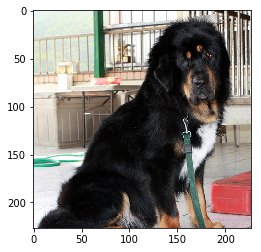

In [1]:
import numpy as np
import time
from alexnet import build_alexnet, print_prob, load_process_image,\
                    unprocess_image
import tensorflow as tf
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

ct_path = "data/dog.png"
st_path = "data/starry_night.jpg"
PIX_MEAN = [103.939, 116.779, 123.68]

ct_im0, ct_im1 = load_process_image(ct_path, PIX_MEAN)
st_im0, st_im1 = load_process_image(st_path, PIX_MEAN)
plt.imshow(ct_im0.astype(np.uint8))
plt.show()
# plt.imshow(st_im0.astype(np.uint8))
# plt.show()

# Load net from https://www.cs.toronto.edu/~guerzhoy/tf_alexnet/
net_data = np.load(open("model/bvlc_alexnet.npy", "rb"),\
                   encoding="latin1").item()

content_layers = ('conv4/Relu', 'conv5/Relu')
style_layers = ('conv1/Relu', 'conv2/Relu', 'conv3/Relu', 'conv4/Relu', 'conv5/Relu')

# Build Network 
xdim = (227,227,3)
ydim = 1000

In [2]:


g = tf.Graph()
with g.as_default(), tf.Session() as sess:
    x = tf.placeholder(tf.float32, (None,) + xdim)
    alexnet = build_alexnet(x, net_data)
    dirpath = 'logs_grad'

    # Calculate context and style features
    c_feat = {}
    s_feat = {}

    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)
    with tf.name_scope("context_feat"):
        for c_layer in content_layers:
            c_feat[c_layer] =\
            sess.run(alexnet.graph.get_operation_by_name(c_layer).outputs[0],\
                                feed_dict={x:[ct_im1]})
    with tf.name_scope("style_feat"):
        for s_layer in style_layers:
            feats =\
            sess.run(alexnet.graph.get_operation_by_name(s_layer).outputs[0],\
                                feed_dict={x:[st_im1]})
            feats = np.reshape(feats, (-1, feats.shape[3]))
            g_mat = np.matmul(feats.T, feats)/feats.size
            s_feat[s_layer] = g_mat
    # output = sess.run(alexnet, feed_dict = {x:[ct_im1]})
    # print_prob(output[0,:], './synset.txt')
del alexnet#, ct_im1, st_im1, ct_im0, st_im0

In [5]:
ct_im1[np.newaxis,:].shape

(1, 227, 227, 3)

In [3]:
alexnet = []
#ini_img = tf.random_normal((1,)+xdim)*0.256*125
ini_img = tf.zeros((1,)+xdim)*0.256*125
img = tf.Variable(ini_img, name="input_rand")
#img = tf.Variable(np.copy(ct_im1[np.newaxis,:].astype(np.float32)), name="input_rand")
n_alexnet = build_alexnet(img, net_data)

In [10]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    print(c_layer)
    #cfeat = sess.run(n_alexnet.graph.get_operation_by_name(c_layer).outputs[0])
    #print(sess.run(img))

conv4/Relu


In [18]:
cfeat[0,0,0,0:10]- c_feat[c_layer][0,0,0,0:10]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [6]:
from functools import reduce


c_losses = []
c_loss = 0
with tf.name_scope("cont_loss"):
    for c_layer in content_layers:
        #c_losses += [ \
        #        tf.nn.l2_loss(n_alexnet.graph.get_operation_by_name(c_layer)\
        #              .outputs[0] - c_feat[c_layer])/c_feat[c_layer].size]
        c_losses += [ \
                tf.nn.l2_loss(n_alexnet.graph.get_operation_by_name(c_layer)\
                      .outputs[0] - c_feat[c_layer])/c_feat[c_layer].size]
    c_loss = reduce(tf.add, c_losses) # why not reduce_sum
    #c_loss = reduce(tf.add, np.array([0,0,0]).astype(np.float32))
                     
s_losses = []
s_loss = 0
with tf.name_scope("style_loss"):
    for s_layer in style_layers:
        op = n_alexnet.graph.get_operation_by_name(s_layer).outputs[0]
        _, height, width, channel = map(lambda i: i.value, op.get_shape())
        size = height * width * channel
        feats = tf.reshape(op, (-1, channel))
        gram = tf.matmul(tf.transpose(feats), feats) / size
        print(gram.get_shape(), s_feat[s_layer].shape)
        s_losses += [tf.nn.l2_loss(gram -\
                        s_feat[s_layer])/s_feat[s_layer].size]
    s_loss = reduce(tf.add, s_losses) # why not reduce_sum
    #s_loss = reduce(tf.add, np.array([0,0,0]).astype(np.float32))

                     
loss = c_loss + 5*s_loss

(96, 96) (96, 96)
(256, 256) (256, 256)
(384, 384) (384, 384)
(384, 384) (384, 384)
(256, 256) (256, 256)


0  closs 210.98526 sloss 800.0338


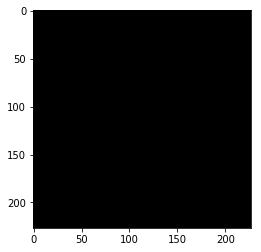

100  closs 124.80909 sloss 800.02277


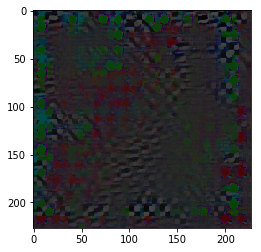

200  closs 40.77059 sloss 800.0711


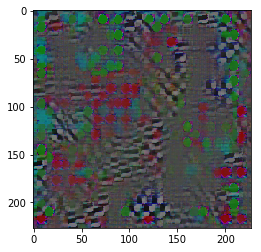

300  closs 26.822803 sloss 800.062


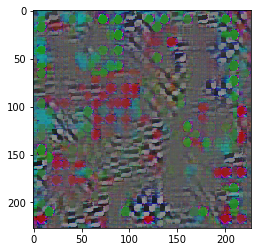

400  closs 21.914507 sloss 799.5469


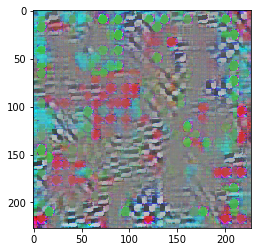

500  closs 22.738443 sloss 745.5579


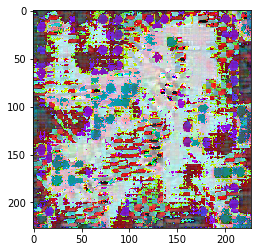

600  closs 19.409658 sloss 569.5249


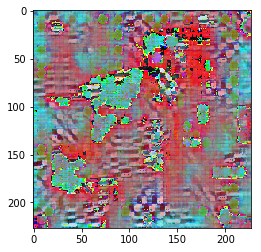

KeyboardInterrupt: 

In [7]:
t_step = tf.train.AdamOptimizer(learning_rate=.001, beta1=0.9, beta2=0.999)\
            .minimize(loss)

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

def print_progress(i):
    print(i, ' closs', sess.run(c_loss), 'sloss', sess.run(s_loss))
imgorig, _ = sess.run([img, t_step])
max_iter = 1000
for i in range(max_iter):
    # print(i)
    if i % 100 == 0:
        print_progress(i)
        im_out = sess.run(n_alexnet.graph.\
                get_operation_by_name('input_rand').outputs[0])
        im_out1 = im_out-im_out.min()
        im_out1 = np.reshape(im_out1, xdim)
        temp1 = np.copy(im_out1[:, :, 2])
        temp2 = np.copy(im_out1[:, :, 0])
        im_out1[:, :, 0] = temp1
        im_out1[:, :, 2] = temp2
        plt.imshow(im_out1)
        plt.show()
    sess.run(t_step)
    
    # TODO stoping condition
print_progress(i)
im_out = sess.run(n_alexnet.graph.\
                get_operation_by_name('input_rand').outputs[0])

# im_out_f = unprocess_image(im_out,PIX_MEAN).reshape(xdim)
# plt.imshow(im_out_f.astype(np.uint8))
# plt.show()

sess.close()
print('done')

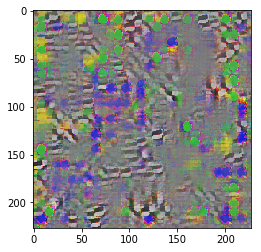

In [16]:
im_out1 = im_out-im_out.min()
im_out1 = np.reshape(im_out1, xdim)
im_out1.max()
plt.imshow(im_out1)
plt.show()

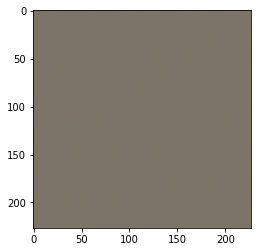

(array([[123.4985  , 116.71088 , 103.91417 ],
        [123.52552 , 116.75909 , 103.973145],
        [123.52791 , 116.732056, 103.92828 ],
        [123.53605 , 116.68868 , 103.84645 ],
        [123.576416, 116.70142 , 103.91568 ],
        [123.60948 , 116.72931 , 104.12508 ],
        [123.74897 , 116.85064 , 104.00873 ],
        [123.78356 , 116.849205, 104.01678 ],
        [123.71095 , 116.85617 , 104.01179 ],
        [123.613716, 116.8376  , 104.01801 ],
        [123.647934, 116.8983  , 104.05554 ],
        [123.6177  , 116.82199 , 104.00057 ],
        [123.55488 , 116.86676 , 104.09326 ],
        [123.50971 , 116.89568 , 104.094864]], dtype=float32),
 array([[242., 247., 248.],
        [248., 250., 247.],
        [239., 250., 247.],
        [233., 245., 241.],
        [231., 242., 245.],
        [232., 242., 245.],
        [237., 248., 244.],
        [238., 249., 240.],
        [236., 247., 242.],
        [236., 247., 240.],
        [236., 247., 245.],
        [236., 247., 242.],
   

In [6]:
def uunprocess_image(im1, mean_pix):
    im1 += mean_pix
    temp1 = np.copy(im1[:, :, 2])
    temp2 = np.copy(im1[:, :, 0])
    im1[:, :, 0] = temp1
    im1[:, :, 2] = temp2
    return im1
im_out = im_out.reshape(xdim)
im_out_f = uunprocess_image(np.copy(im_out),PIX_MEAN)
plt.imshow(im_out_f.astype(np.uint8))
plt.show()

im_out_f[0:14,0,:], ct_im0[0:14,0,:]
# plt.imshow(ct_im0.astype(np.uint8))
# plt.show()
# im_out_f[0,0,0], ct_im0[0,0,0]

In [12]:
g = n_alexnet.graph
v = g.get_collection('trainable_variables')[3]
print(v)
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    vval= sess.run(v)


<tf.Variable 'conv2/Variable:0' shape=(5, 5, 48, 256) dtype=float32_ref>


In [6]:
imgorig -= imgorig.min()
print(imgorig[0,1:10,0,0])
print(im_out[0,1:10,0,0])

[174.77005 104.24028 104.49273 167.9331  153.46185 137.59761 129.60443
  86.57919 133.20837]
[175.99706  105.924225 106.174286 169.59503  154.60938  138.97945
 130.6359    86.84242  133.82047 ]


In [24]:
# Check if weights change
print(v)
print(vval.shape)
print(vval[1,1,1:10,1])
print(net_data['conv2'][0].shape)
print(net_data['conv2'][0][1,1,1:10,1])

<tf.Variable 'conv2/Variable:0' shape=(5, 5, 48, 256) dtype=float32_ref>
(5, 5, 48, 256)
[ 0.03241688  0.01966027 -0.03869275 -0.08747857  0.01339802  0.00605746
 -0.01888259  0.02550369 -0.02350341]
(5, 5, 48, 256)
[ 0.03241688  0.01966027 -0.03869275 -0.08747857  0.01339802  0.00605746
 -0.01888259  0.02550369 -0.02350341]


In [11]:
 g.get_collection('trainable_variables')

[<tf.Variable 'conv1/Variable:0' shape=(11, 11, 3, 96) dtype=float32_ref>,
 <tf.Variable 'conv1/Variable_1:0' shape=(96,) dtype=float32_ref>,
 <tf.Variable 'conv2/Variable:0' shape=(5, 5, 48, 256) dtype=float32_ref>,
 <tf.Variable 'conv2/Variable_1:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'conv3/Variable:0' shape=(3, 3, 256, 384) dtype=float32_ref>,
 <tf.Variable 'conv3/Variable_1:0' shape=(384,) dtype=float32_ref>,
 <tf.Variable 'conv4/Variable:0' shape=(3, 3, 192, 384) dtype=float32_ref>,
 <tf.Variable 'conv4/Variable_1:0' shape=(384,) dtype=float32_ref>,
 <tf.Variable 'conv5/Variable:0' shape=(3, 3, 192, 256) dtype=float32_ref>,
 <tf.Variable 'conv5/Variable_1:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'fc6/Variable:0' shape=(9216, 4096) dtype=float32_ref>,
 <tf.Variable 'fc6/Variable_1:0' shape=(4096,) dtype=float32_ref>,
 <tf.Variable 'fc7/Variable:0' shape=(4096, 4096) dtype=float32_ref>,
 <tf.Variable 'fc7/Variable_1:0' shape=(4096,) dtype=float32_ref>,
 <tf.Vari